Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с 2024-05-31 по 2024-06-06 включительно. Для эксперимента были задействованы 2 и 1 группы. 
В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 
Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 
## Задание
Проанализировать данные А/B-теста.
1) Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
2) Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали именно так? 
3) Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
4) Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

In [ ]:
# Выгружаем данные и подключаем необходимые библиотеки.
import pandahouse as pandahouse
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import poisson
from scipy import stats
import statistics as st

connection = {
    'host': 'https://clickhouse.lab.karpov.courses/',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20240620'
}

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) >= '2024-05-31' and toDate(time) <= '2024-06-06'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

Среднее 1 группы:  0.216773994120072  Среднее 2 группы:  0.2161016893237817
Медиана 1 группы:  0.2058823529411764  Медиана 2 группы:  0.1532846715328467
Мода 1 группы:  0    0.2
Name: ctr, dtype: float64  Мода 1 группы:  0    0.333333
Name: ctr, dtype: float64


MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

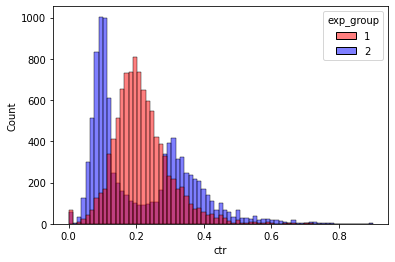

In [47]:
# Сделаем графики в seaborn 

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

#T-тест

stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')


<Axes: xlabel='ctr', ylabel='Count'>

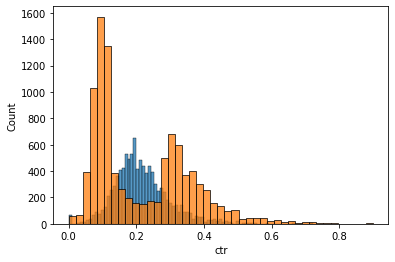

In [19]:
# Сглаженный CTR

def get_smothed_ctr_1(user_likes_1, user_views_1, global_ctr_1, alpha):
    smothed_ctr_1 = (user_likes_1 + alpha * global_ctr_1) / (user_views_1 + alpha)
    smothed_ctr_2 = (user_likes_2 + alpha * global_ctr_2) / (user_views_2 + alpha)
    return smothed_ctr_1

def get_smothed_ctr_2(user_likes_2, user_views_2, global_ctr_2, alpha):
    smothed_ctr_2 = (user_likes_2 + alpha * global_ctr_2) / (user_views_2 + alpha)
    return smothed_ctr_2

global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

user_likes_1 = df[df.exp_group == 1].likes.sum()
user_likes_2 = df[df.exp_group == 2].likes.sum()
user_views_1 = df[df.exp_group == 1].views.sum()
user_views_2 = df[df.exp_group == 2].views.sum()

smothed_ctr_1 = get_smothed_ctr_1(user_likes_1, user_views_1, global_ctr_1, alpha = 0.05)
smothed_ctr_2 = get_smothed_ctr_2(user_likes_2, user_views_2, global_ctr_2, alpha = 0.05)

# Графики распределений CTR по группам до сглаживания
group1 = df[df.exp_group == 1].copy()
sns.histplot(data = group1.ctr, 
             kde = False)

group2 = df[df.exp_group == 2].copy()
sns.histplot(data = group2.ctr, 
             kde = False)

Ttest_indResult(statistic=1.9460491517027683, pvalue=0.05166679015318526)
MannwhitneyuResult(statistic=55528353.0, pvalue=2.396534039374286e-50)


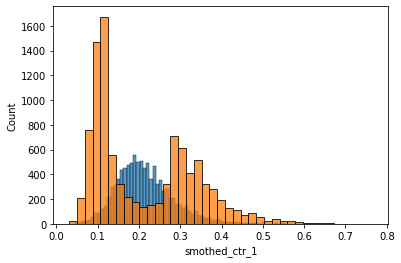

In [14]:
group1['smothed_ctr_1'] = df.apply(
    lambda x: get_smothed_ctr_1(x['likes'], x['views'], global_ctr_1, alpha = 5), axis=1)

group2['smothed_ctr_2'] = df.apply(
    lambda x: get_smothed_ctr_2(x['likes'], x['views'], global_ctr_2, alpha = 5), axis=1)

sns.histplot(group1.smothed_ctr_1, 
             kde = False)

sns.histplot(group2.smothed_ctr_2, 
             kde = False)

ttest = stats.ttest_ind(group1.smothed_ctr_1,
                group2.smothed_ctr_2,
                equal_var=False)

mannwhit = stats.mannwhitneyu(group1.smothed_ctr_1,
                group2.smothed_ctr_2,
                alternative = 'two-sided')
print(ttest)
print(mannwhit)

<Axes: ylabel='Count'>

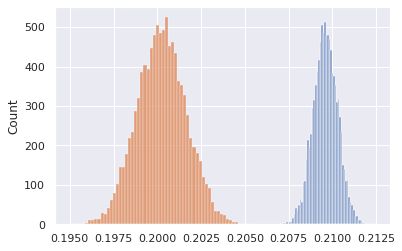

In [70]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=10000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

In [ ]:
# Не перескаются, значит группы имеют различия.

<Axes: ylabel='Count'>

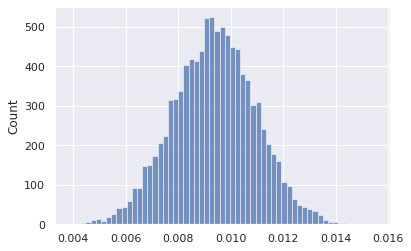

In [71]:
#Разница между глобальными CTR

sns.histplot(ctr1 - ctr2)


In [ ]:
# Разность близка к 0, но все же находится правее, соответственно, различия в группах есть.

In [77]:
qq = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) >= '2024-05-31' and toDate(time) <= '2024-06-06'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

dff = pandahouse.read_clickhouse(qq, connection=connection)

In [22]:
#тест Манна-Уитни видит отличие
stats.mannwhitneyu(dff[dff.exp_group == 1].bucket_ctr, 
                   dff[dff.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)

In [25]:
#и t-тест тоже
stats.ttest_ind(dff[dff.exp_group == 1].bucket_ctr, 
                   dff[dff.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.614819358149381, pvalue=4.592644937473873e-07)